# Lecture 19: Convolutional Neural Networks in Keras
***

![digits](figs/mnist.png "mnist data")


***

In this notebook we'll experiment with using Keras and convolutional neural networks to classify handwritten digits from the MNIST data set.  

### Problem 1: Setup and Data Exploration  
***

If you do not have Keras installed on your machine, you can do this quickly and easily.  

In MacOS or Linux you can install Keras using 

In [ ]:
conda install -c conda-forge keras 

If you're running Windows then you can install Keras from the `conda prompt` with 

In [ ]:
conda install --channel https://conda.anaconda.org/conda-forge keras

**Part A**: First, we'll load the MNIST data directly from Keras. 

In [1]:
from keras.datasets import mnist

(X_train, y_train), (X_valid, y_valid) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 5s 0us/step


Note that the data is already partitioned into training and validation sets.  Because training CNNs is a time-intensive process, we'll reduce the size of both data sets so that they're more manageable. 

In [2]:
num_train, num_valid = 5000, 1000

X_train = X_train[:num_train]
y_train = y_train[:num_train]
X_valid = X_valid[:num_valid]
y_valid = y_valid[:num_valid]

**Q**: What are the shape and dimensions of the data? 

In [4]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(5000, 28, 28) (5000,) (1000, 28, 28) (1000,)


**Part B**: When working with CNNs we need to reshape our data to conform to general image types, which typically have multiple color bands.  We need to reshape the data arrays to have 4 dimensions, where the additional data corresponds to a single color band.  How we do this will depend on whether we're using `Theano` or `TensorFlow` as the Keras backed.  

In [5]:
from keras import backend as K

# set the size of the images 
img_rows, img_cols = 28, 28

# Add the color-band dimension either before or after the image dimensions 
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print("new data dimension: ", X_train.shape)

new data dimension:  (5000, 28, 28, 1)


We'll also normalize the pixel data so that intensities fall between $[0,1]$ instead of $[0,255]$. 

In [6]:
X_train = X_train.astype('float32') / 255.0 
X_valid = X_valid.astype('float32') / 255.0 

**Part C**: Finally, we need to modify the data labels so that they correspond to one-hot-encoded labels.  Luckily, Keras has a function to do this for us automatically. 

In [7]:
import numpy as np

from keras.utils import np_utils 

num_classes = len(np.unique(y_train))

y_train_onehot = np_utils.to_categorical(y_train, num_classes) 
y_valid_onehot = np_utils.to_categorical(y_valid, num_classes) 

print("example one-hot-encoded labels: ")
for ii in range(3):
    print("digit label: {:d}, one-hot-label: {}".format(y_train[ii], y_train_onehot[ii]))

example one-hot-encoded labels: 
digit label: 5, one-hot-label: [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
digit label: 0, one-hot-label: [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
digit label: 4, one-hot-label: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


**Part D**: Finally, let's look at a few of the images, just to make sure we haven't messed anything up.

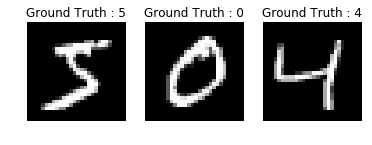

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6,3))
for ii, ax in enumerate(axes):
    if K.image_data_format() == 'channels_first':
        ax.imshow(X_train[ii,0,:,:], cmap='gray')
    else:
        ax.imshow(X_train[ii,:,:,0], cmap='gray')
    ax.set_title("Ground Truth : {:d}".format(y_train[ii]))
    ax.axis('off')

### Problem 2: Our First Simple CNN
***

**Part A**: We will train a CNN with the following architecture.  Note that we're just working from good starting points here.  In practice we would want to spend time analyzing and evaluating multiple architectures, activations, and hyperparameters. 

Our CNN will be comprised of 

- 3 Convolutional Layers of increasing number of filters, each followed by a MaxPool Layer 
- A Dense hidden layer with 128 neurons and a linear activation function 
- An output layer with softmax activation 

First, we need to load all of the necessary modules from Keras 

In [9]:
import keras

from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Additionally, we need to define certain hyperparameter like batch_size, number of epochs, etc

In [10]:
batch_size = 64 
num_epochs = 20 

Finally, we initialize a model and start adding layers 

In [11]:
# initialize model 
simple_model = Sequential()

# Convolutional layer with 32 3x3 filters followed by 2x2 MaxPool 
simple_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='same'))
simple_model.add(MaxPooling2D((2, 2),padding='same'))

# Convolutional layer with 64 3x3 filters followed by 2x2 MaxPool 
simple_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
simple_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

# Convolutional layer with 128 3x3 filters followed by 2x2 MaxPool 
simple_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
simple_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

# Flatten and feed into dense layer 
simple_model.add(Flatten())
simple_model.add(Dense(128, activation='relu'))

# Output layer 
simple_model.add(Dense(num_classes, activation='softmax'))

Finally, we have to specify the loss function and solver we'll use during training, as well as the metric that we want reported to us throughout the process. 

In [12]:
loss = keras.losses.categorical_crossentropy
optimizer = keras.optimizers.Adam()
metrics = ["accuracy"]

And now we tell Keras to compile the model

In [13]:
simple_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Once our model is set, Keras can print a nice summary for us 

In [14]:
simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

**Part B**: Now we're ready to actually train the model! You might want to grab a magazine or something because this'll take a minute!   

In [15]:
simple_train = simple_model.fit(X_train, y_train_onehot, batch_size=batch_size, epochs=num_epochs, verbose=1,
                                validation_data=(X_valid, y_valid_onehot))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 9s 2ms/step - loss: 0.8163 - acc: 0.7448 - val_loss: 0.3208 - val_acc: 0.9050
Epoch 2/20
5000/5000 [==============================] - 8s 2ms/step - loss: 0.1805 - acc: 0.9446 - val_loss: 0.1357 - val_acc: 0.9480
Epoch 3/20
5000/5000 [==============================] - 9s 2ms/step - loss: 0.0999 - acc: 0.9680 - val_loss: 0.1378 - val_acc: 0.9540
Epoch 4/20
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0943 - acc: 0.9720 - val_loss: 0.0816 - val_acc: 0.9670
Epoch 5/20
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0430 - acc: 0.9878 - val_loss: 0.1076 - val_acc: 0.9590
Epoch 6/20
5000/5000 [==============================] - 9s 2ms/step - loss: 0.0545 - acc: 0.9806 - val_loss: 0.0911 - val_acc: 0.9640
Epoch 7/20
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0304 - acc: 0.9914 - val_loss: 0.1002 - val_acc: 0.9650
Epoch 8/20
500

**Part C**: We can already get an idea of how we did from the training output, but let's get the final results directly from the training history and print them. 

In [16]:
print("training loss = {:.3f},  training accuracy = {:.3f}".
      format(simple_train.history['loss'][-1], simple_train.history['acc'][-1]))

training loss = 0.000,  training accuracy = 1.000


We can also print the loss and accuracy on the validation data. 

In [17]:
print("validation loss = {:.3f},  validation accuracy = {:.3f}".
      format(simple_train.history['val_loss'][-1], simple_train.history['val_acc'][-1]))

validation loss = 0.062,  validation accuracy = 0.981


**Part D**: Finally, let's make a plot of the training and validation accuracies as they evolve over the training process. 

''

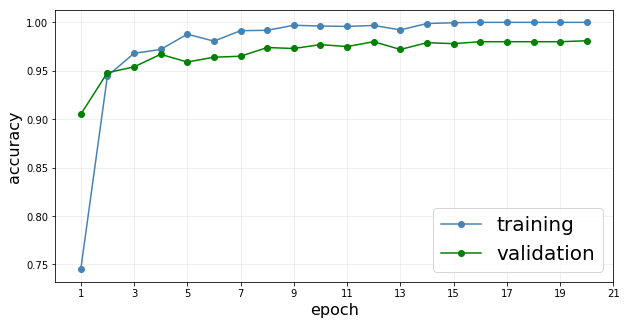

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(range(1,num_epochs+1), simple_train.history['acc'], color="steelblue", marker="o", label="training")
ax.plot(range(1,num_epochs+1), simple_train.history['val_acc'], color="green", marker="o", label="validation")
ax.grid(alpha=0.25)
ax.legend(loc="lower right", fontsize=20)
plt.xticks(range(1,num_epochs+2,2))
ax.set_xlabel("epoch", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
;

### Problem 3: Combating Overfitting 
*** 

While it doesn't appear that we really have an overfitting problem here, let's pretend that we do so we can explore methods to mitigate it.  

We'll do this by adding Dropout layers after each of the Conv-MaxPool layers and after the Dense hidden layer.  You can do this by inserting layers of the form 

`simple_model.add(Dropout(p))`

in the architecture specifications above. The parameter $p$ indicates what proportions of units to randomly ignore during training.  Typically we start with small values of $p$ and then increase them as we go farther into the network.  As a first pass, try using $p = 0.25, 0.25, 0.4, 0.3$ for the four DropOut layers. 

Repeat the training and evaluation process performed in **Problem 2**.  How did you do? 

In [20]:
# initialize model 
simple_model = Sequential()

# Convolutional layer with 32 3x3 filters followed by 2x2 MaxPool 
simple_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='same'))
simple_model.add(MaxPooling2D((2, 2),padding='same'))
simple_model.add(Dropout(0.25))

# Convolutional layer with 64 3x3 filters followed by 2x2 MaxPool 
simple_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
simple_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
simple_model.add(Dropout(0.25))

# Convolutional layer with 128 3x3 filters followed by 2x2 MaxPool 
simple_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
simple_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
simple_model.add(Dropout(0.25))

# Flatten and feed into dense layer 
simple_model.add(Flatten())
simple_model.add(Dense(128, activation='relu'))
simple_model.add(Dropout(0.4))

# Output layer 
simple_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
simple_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Actually train the model
simple_train = simple_model.fit(X_train, y_train_onehot, batch_size=batch_size, epochs=num_epochs, verbose=1,
                                validation_data=(X_valid, y_valid_onehot))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 11s 2ms/step - loss: 0.9027 - acc: 0.6906 - val_loss: 0.2133 - val_acc: 0.9260
Epoch 2/20
5000/5000 [==============================] - 10s 2ms/step - loss: 0.2446 - acc: 0.9268 - val_loss: 0.1340 - val_acc: 0.9530
Epoch 3/20
5000/5000 [==============================] - 10s 2ms/step - loss: 0.1719 - acc: 0.9502 - val_loss: 0.1094 - val_acc: 0.9600
Epoch 4/20
5000/5000 [==============================] - 11s 2ms/step - loss: 0.1421 - acc: 0.9594 - val_loss: 0.0966 - val_acc: 0.9660
Epoch 5/20
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1058 - acc: 0.9680 - val_loss: 0.0675 - val_acc: 0.9790
Epoch 6/20
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0900 - acc: 0.9708 - val_loss: 0.1005 - val_acc: 0.9680
Epoch 7/20
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0966 - acc: 0.9702 - val_loss: 0.0719 - val_acc: 0.9780
Epoch 8

In [21]:
print("training loss = {:.3f},  training accuracy = {:.3f}".
      format(simple_train.history['loss'][-1], simple_train.history['acc'][-1]))
print("validation loss = {:.3f},  validation accuracy = {:.3f}".
      format(simple_train.history['val_loss'][-1], simple_train.history['val_acc'][-1]))

training loss = 0.030,  training accuracy = 0.990
validation loss = 0.045,  validation accuracy = 0.986


''

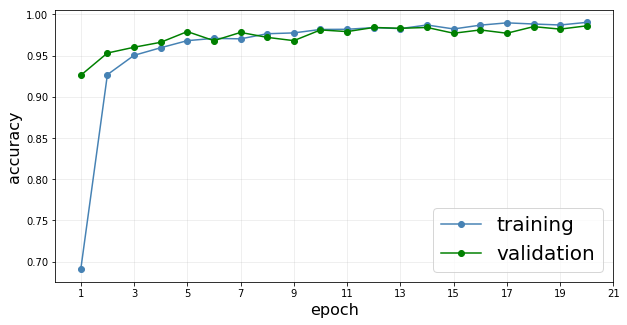

In [22]:
# Plot the outputs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(range(1,num_epochs+1), simple_train.history['acc'], color="steelblue", marker="o", label="training")
ax.plot(range(1,num_epochs+1), simple_train.history['val_acc'], color="green", marker="o", label="validation")
ax.grid(alpha=0.25)
ax.legend(loc="lower right", fontsize=20)
plt.xticks(range(1,num_epochs+2,2))
ax.set_xlabel("epoch", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
;

### Problem 4: More Interesting Data 
*** 

As people became board with the vanilla MNIST data, lots of alternative data sets popped up.  A popular one is the so called `fashion_mnist` dataset.  Go back to **Problem 2** and try your network out on this data set instead. 

In [23]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_valid, y_valid) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 21s 5us/step
